In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, datasets, transforms
import torchvision.transforms as transforms
import pennylane_qiskit
from torch.autograd import Variable
from torch.distributions import Categorical
from torchvision.transforms import Resize
import torch.optim as optim
from torch.optim import Optimizer # 'required' was removed here
from ipywidgets import *
print('Doe we get CUDA Power? ',torch.cuda.is_available())
print("CUDA WHO? CUDA:",torch.cuda.current_device() )
print("CUDA who WHO? Cuda : ", torch.cuda.get_device_name(torch.cuda.current_device()))
import matplotlib.image as img
# Pennylane
import pennylane as qml
from pennylane import numpy as np
import scipy
import os
import pyzx as zx
import qiskit
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import progress
import time
import csv
import pandas as pd
import pylatexenc
import qiskit

from qiskit import *
from qiskit import IBMQ
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = "svg"
from qiskit.tools.parallel import parallel_map
import qiskit.tools.jupyter
%qiskit_job_watcher
%qiskit_progress_bar
%matplotlib inline
print('libraries Imported')

Doe we get CUDA Power?  True
CUDA WHO? CUDA: 0
CUDA who WHO? Cuda :  NVIDIA GeForce 940MX


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

libraries Imported


##Install whichever library is not installed in your system by :
* conda install *missing library*
* pip install   *missing library*

Here we define the circuit parameters for a random circuit. You may design your own circuit. 
* I designed my circuit in Pennylane > Converted it into qasm language by PyZX > then also used the QASM Code to develop PyZX circuits and in Qiskit. 

Tutorial below:

In [68]:

n_qubits = 4             # Number of qubits
q_depth = 1                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [69]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [70]:
dev = qml.device("qiskit.aer", wires=n_qubits,  shots=1000)
@qml.qnode(dev, interface="torch", diff_method="best")

def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits) #(9,4)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [71]:
q_input_features = torch.tensor([np.pi*.1, np.pi*0.2, np.pi*0.3], requires_grad=True)
q_weights_flat = torch.tensor([np.pi*.1, np.pi*0.2, np.pi*0.3, np.pi*0.4 ], requires_grad=True)
result = quantum_net(q_input_features, q_weights_flat)
print(quantum_net.draw())

 0: ──H──RY(0.314)──╭C───RY(0.314)─────────────┤ ⟨Z⟩ 
 1: ──H──RY(0.628)──╰X──╭C──────────RY(0.628)──┤ ⟨Z⟩ 
 2: ──H──RY(0.942)──╭C──╰X──────────RY(0.942)──┤ ⟨Z⟩ 
 3: ──H─────────────╰X───RY(1.26)──────────────┤ ⟨Z⟩ 



Pennylane offers to convert its circuits into QASM which is the Open Quantum Assembly Language. 
It may be helpful when you are trying to work with various Quantum Libraries.

In [72]:
s=dev._circuit.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[4];
h q[0];
h q[1];
h q[2];
h q[3];
ry(pi/10) q[0];
ry(pi/5) q[1];
ry(3*pi/10) q[2];
cx q[0],q[1];
cx q[2],q[3];
cx q[1],q[2];
ry(pi/10) q[0];
ry(pi/5) q[1];
ry(3*pi/10) q[2];
ry(2*pi/5) q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];



PyZX offers Rotation Function for RX, RZ , but not for RY. For example, in the code example a below, since I couldn't find RY, I tested the above required QASM code with RZ Function.

In [73]:
a = zx.qasm("""
            qreg q[4];
            creg c[4];
            h q[0];
            h q[1];
            h q[2];
            h q[3];
            rz(pi*1/10) q[0];
            rz(pi*1/5) q[1];
            rz(3*pi/10) q[2];
            cx q[0],q[1];
            cx q[2],q[3];
            cx q[1],q[2];
            rz(pi*1/10) q[0];
            rz(pi*1/5) q[1];
            rz(3*pi/10) q[2];
            rz(2*pi/5) q[3];
            measure q[0] -> c[0];
            measure q[1] -> c[1];
            measure q[2] -> c[2];
            measure q[3] -> c[3];""" )
zx.draw_d3(a)


The Nodes of the PyZX circuit are movable if You drag them by mouse. Come on try it!

A Y rotation of alpha should be :
   RY(alpha) =  RZ(-pi/2)*RX(alpha)*RZ(pi/2)   -Aleks Kissinger(The Creater)

In [74]:
qc = zx.qasm("""
            qreg q[4];
            creg c[4];
            
            h q[0];
            h q[1];
            h q[2];
            h q[3];
            
            rz(-pi/2) q[0];
            h q[0];
            rx(pi*1/10) q[0];
            h q[0];
            rz(pi/2) q[0];
            
            rz(-pi/2) q[1];
            h q[1];
            rx(pi*1/10) q[1];
            h q[1];
            rz(pi/2) q[1];
            
            rz(-pi/2) q[2];
            h q[2];
            rx(pi*1/10) q[2];
            h q[2];
            rz(pi/2) q[2];
            
            cx q[0],q[1];
            cx q[2],q[3];
            cx q[1],q[2];
            
            rz(-pi/2) q[0];
            h q[0];
            rx(pi*1/10) q[0];
            h q[0];
            rz(pi/2) q[0];
            
            rz(-pi/2) q[1];
            h q[1];
            rx(pi*1/10) q[1];
            h q[1];
            rz(pi/2) q[1];
            
            rz(-pi/2) q[2];
            h q[2];
            rx(pi*1/10) q[2];
            h q[2];
            rz(pi/2) q[2];
            
            rz(-pi/2) q[3];
            h q[3];
            rx(pi*1/10) q[3];
            h q[3];
            rz(pi/2) q[3];
            
            measure q[0] -> c[0];
            measure q[1] -> c[1];
            measure q[2] -> c[2];
            measure q[3] -> c[3];""" )
zx.draw_d3(qc)


So, the required circuit should look like this in ZX Calculus. Why It looks like this? You need to study ZX Calculus. Its application is in Error Correction, Reducting Cliffords. 

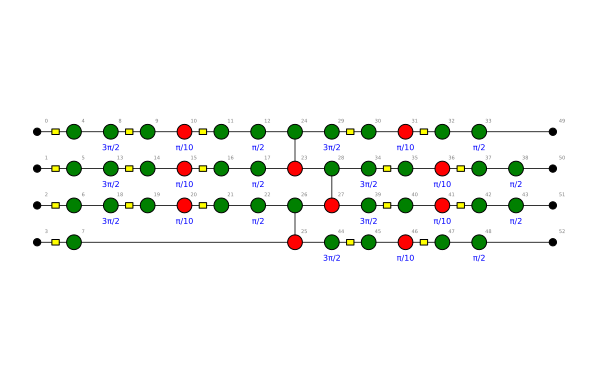

In [75]:
zx.draw_matplotlib(qc,labels=True,h_edge_draw='box', figsize=(8, 5))

If You also want to picturise the position of Hadamard gates, try the code above.

You May also list the gate information of your circuit

In [76]:
qc.gates

[HAD(0),
 HAD(1),
 HAD(2),
 HAD(3),
 ZPhase(0,phase=-1/2),
 HAD(0),
 XPhase(0,phase=1/10),
 HAD(0),
 ZPhase(0,phase=1/2),
 ZPhase(1,phase=-1/2),
 HAD(1),
 XPhase(1,phase=1/10),
 HAD(1),
 ZPhase(1,phase=1/2),
 ZPhase(2,phase=-1/2),
 HAD(2),
 XPhase(2,phase=1/10),
 HAD(2),
 ZPhase(2,phase=1/2),
 CNOT(0,1),
 CNOT(2,3),
 CNOT(1,2),
 ZPhase(0,phase=-1/2),
 HAD(0),
 XPhase(0,phase=1/10),
 HAD(0),
 ZPhase(0,phase=1/2),
 ZPhase(1,phase=-1/2),
 HAD(1),
 XPhase(1,phase=1/10),
 HAD(1),
 ZPhase(1,phase=1/2),
 ZPhase(2,phase=-1/2),
 HAD(2),
 XPhase(2,phase=1/10),
 HAD(2),
 ZPhase(2,phase=1/2),
 ZPhase(3,phase=-1/2),
 HAD(3),
 XPhase(3,phase=1/10),
 HAD(3),
 ZPhase(3,phase=1/2)]

In [77]:
l= zx.print_matrix(qc) #I dont know why its so zoomed out
l

Label(value='\\begin{equation}\n2^{-2}\n\\begin{pmatrix}\n1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & …

This is how the whole QuantumCircuit can be prepresented as mathematical matrix

In [78]:
k = qc.to_matrix(preserve_scalar=True)
k

array([[ 0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ,
         0.25      -0.j        ,  0.25      -0.j        ],
       [ 0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j,
         0.23776413+0.07725425j, -0.23776413-0.07725425j],
       [ 0.20225425+0.14694631j, -0.20225425-0.14694631j,
        -0.2

In [79]:
g = qc.to_graph()
g


Graph(53 vertices, 52 edges)

In [80]:
g.normalize() # Reposition nodes horizontally to look nicer
zx.draw(g)

Following two code examples Show the count of Edges and vertex of Circuit connections.

In [81]:
print(qc)
print("All edges: ", list(g.edges()))
print("\nThe neighbors of a particular vertex: ", list(g.neighbors(14)))

Circuit(4 qubits, 42 gates)
All edges:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 13), (6, 18), (7, 25), (8, 9), (9, 10), (10, 11), (11, 12), (12, 24), (13, 14), (14, 15), (15, 16), (16, 17), (17, 23), (18, 19), (19, 20), (20, 21), (21, 22), (22, 26), (23, 24), (23, 28), (24, 29), (25, 26), (25, 44), (26, 27), (27, 28), (27, 39), (28, 34), (29, 30), (30, 31), (31, 32), (32, 33), (33, 49), (34, 35), (35, 36), (36, 37), (37, 38), (38, 50), (39, 40), (40, 41), (41, 42), (42, 43), (43, 51), (44, 45), (45, 46), (46, 47), (47, 48), (48, 52)]

The neighbors of a particular vertex:  [13, 15]


In [82]:
print("vertex count", len(list(g.vertices())))
#print("Combinations of vertices: ", list(g.vertices())
print("edges count", len(list(g.edges())))
#print("Combinations of edges: ", list(g.edges())


vertex count 53
edges count 52


In [83]:
from ipywidgets import widgets
from IPython.display import display, Markdown
qubit_amount =4
from pyzx.simplify import clifford_iter

graph = qc.to_basic_gates().to_graph().copy()
graphs = [zx.draw_matplotlib(graph ,labels=False,h_edge_draw='box')]
names = ["start"]
for gs, n in clifford_iter(graph):
    graphs.append(zx.draw_matplotlib(gs))
    names.append(n)
zx.drawing.pack_circuit_nf(gs,'grg')
graphs.append(zx.draw_matplotlib(gs))
names.append("reposition")

def plotter(rewrite):
    display(Markdown("Rewrite step: " + names[rewrite]))
    display(graphs[rewrite])

w = widgets.interactive(plotter, rewrite=(0,len(graphs)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,50*len(graphs)))
output = w.children[-1]
output.layout.height = "{!s}px".format(200+qubit_amount*20)
slider.value = 0
w

interactive(children=(IntSlider(value=0, description='rewrite', layout=Layout(width='700px'), max=13), Output(…

The above example may help you visualize step by step reduction of Quantum Circuit, if reduced through ZX calculus. The steps are called Iterations. You may slide the slider to see.

Following code is the 3 teration simplification of the original circuit. 

In [84]:
g = qc.to_graph()
g
zx.simplify.spider_simp(g)
zx.draw_d3(g)

spider_simp: 11. 2. 1.  3 iterations


But what if you want to reduce the Circuit completely? Do as follows:

In [98]:
g = qc.to_graph()
g


Graph(53 vertices, 52 edges)

In [86]:
zx.full_reduce(g)
zx.draw_d3(g)

In [87]:
g = qc.to_graph()
g


Graph(53 vertices, 52 edges)

In the Quantum circuit, every Qubit is mapped to another Qubit. Proof? Its given follows:

In [88]:
g1 = g.copy()
# The numbers in the paranthesis are the qubit identities 0, 1 , 2, 3 for 4 qubits of our Circuit.
g1.map_qubits([
    (0,0),(1,0),(2,0),(3,0),
    (0,1),(1,1),(2,1),(3,1),
    (0,2),(1,2),(2,2),(3,2),
    (0,3),(1,3),(2,3),(3,3),
    ])
zx.draw_d3(g1)

In [89]:
e=zx.hsimplify.hpivot_simp(g)

spider_simp: 11. 2. 1.  3 iterations
id_simp: 8.  1 iterations
spider_simp: 7. 6. 1.  3 iterations


Just another representation of the above Normalized circuit with representaion of Hadamard gates in Yellow boxes.

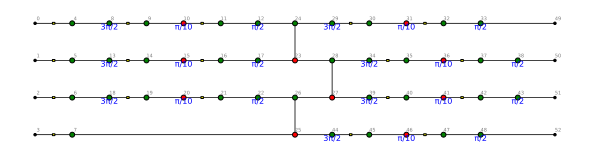

In [90]:
zx.draw_matplotlib(g1,labels=True,h_edge_draw='box')

You May obtain the Gate Stats as follows. It might be important to understand your circuits's components

In [91]:
print(qc.to_basic_gates().stats())


Circuit  on 4 qubits with 42 gates.
        7 is the T-count
        35 Cliffords among which 
        3 2-qubit gates (3 CNOT, 0 other) and
        18 Hadamard gates.


In [92]:
print("Tcount: ",zx.tcount(g)) #Returns the amount of nodes in g that have a non-Clifford phase.
%timeit zx.simulate.calculate_path_sum(g)
#zx.spider_simp(g3,quiet=True)
#zx.d3.draw(g3)

Tcount:  6
912 µs ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We conclude the tutorial by finally coding the same Circuit in Qiskit:

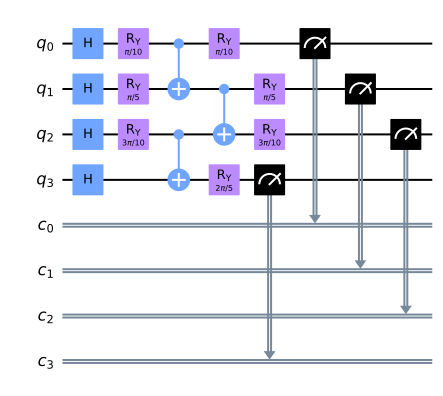

In [94]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
circuit.h(qreg_q[3])
circuit.ry(pi/10, qreg_q[0])
circuit.ry(pi/5, qreg_q[1])
circuit.ry(3*pi/10, qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(pi/10, qreg_q[0])
circuit.ry(pi/5, qreg_q[1])
circuit.ry(3*pi/10, qreg_q[2])
circuit.ry(2*pi/5, qreg_q[3])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])
circuit.draw('mpl', cregbundle=(False) )

In [95]:
#overview of all available backends
from qiskit import IBMQ
total_qubits = 4
IBMQ.save_account('Insert Your own IBM API KEY', overwrite= True)
IBMQ.load_account()
IBMQ.providers()
%matplotlib inline

provider= IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend= provider.backends(filters = lambda  x: x.configuration().n_qubits >= total_qubits and not x.configuration().simulator and x.status().operational == True)

print('least busy backend: ', backend)

ibmqfactory.load_account:WARNING:2021-10-06 22:14:47,970: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  [<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]


{'0000': 5, '0001': 12, '0010': 4, '0011': 13, '0100': 2, '0101': 33, '0110': 4, '0111': 21, '1000': 41, '1001': 76, '1010': 74, '1011': 80, '1100': 27, '1101': 320, '1110': 106, '1111': 206}


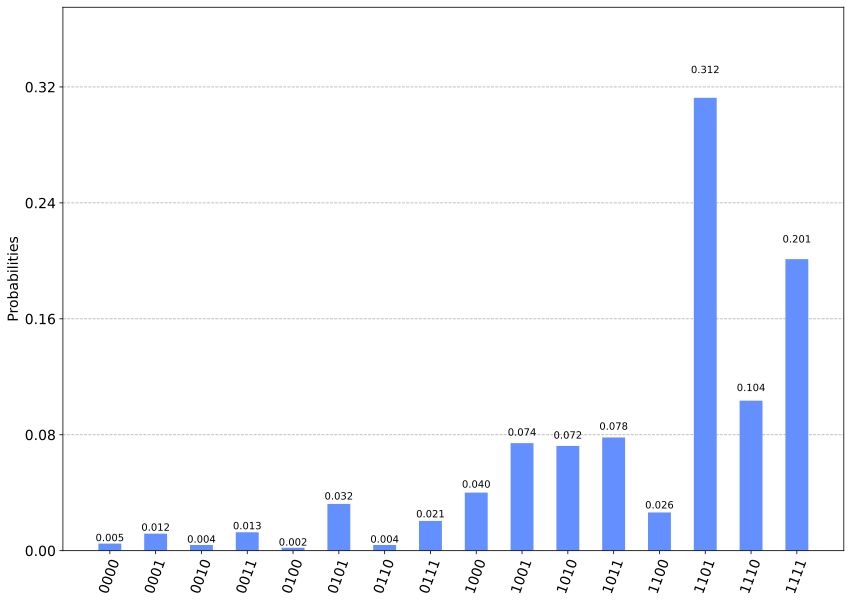

In [96]:
backend = provider.get_backend('ibmq_belem')
result = execute(circuit, backend= backend, shots = 1024).result()
counts = result.get_counts(circuit) 
print(counts)
plot_histogram(counts, figsize= (14,10))



In [97]:
circuit.decompose()